This example examines output from the `elm-pb` example included in the `BOUT-dev` repo. \[It was tested with output from the `next` branch at commit df7c980c3bec3adee17067a3dd9190c2ff79f0db\].

You can use it in two ways, either generate the data or download it. Generate by running `elm-pb` and then copying its `BOUT.inp` (input file), `cbm18_dens8.grid_nx68ny64.nc` (grid file) and `BOUT.dmp.*.nc` (output files) to the directory containing this notebook. Download by running the first Python cell in the 'Setup' section.

Contents:
* Setup
* Load
* Plot
* Animate
* Extras

Setup
=====

In [1]:
# Download data files if you do not have them already
from pathlib import Path
import urllib.request
for filename in ["BOUT.inp", "cbm18_dens8.grid_nx68ny64.nc", "BOUT.dmp.0.nc"]:
    if not Path(filename).exists():
        urllib.request.urlretrieve(f"https://zenodo.org/record/4295926/files/{filename}?download=1", filename)

In [2]:
# set up matplotlib
%matplotlib notebook
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (16, 8)

In [3]:
import numpy as np
from xbout import open_boutdataset

Load
====

In [4]:
# open the Dataset

# Pass chunks argument so that dask can parallelise operations over the time dimension
# (by default the chunk size is the size of the arrays in the files being loaded).
# See http://xarray.pydata.org/en/stable/dask.html#chunking-and-performance
#
# The geometry argument is needed to allow poloidal plots to be made (see below).
# The gridfile is required to provide Rxy, Zxy and psixy arrays to set up the geometry
ds = open_boutdataset(chunks={"t": 1}, geometry="toroidal", gridfilepath="cbm18_dens8.grid_nx68ny64.nc")

# elm-pb saves aligned fields. We want to plot non-aligned, so transform.
# Saving aligned fields is a non-default option, used for backward compatibility, so most models will not need this.
for var in ["U", "P", "Psi"]:
    ds[var] = ds[var].bout.from_field_aligned()

Applying toroidal geometry conventions
Read in:
<xbout.BoutDataset>
Contains:
<xarray.Dataset>
Dimensions:       (t: 41, theta: 64, x: 68, zeta: 16)
Coordinates:
    zShift        (x, theta) float64 dask.array<chunksize=(68, 64), meta=np.ndarray>
    psi_poloidal  (x, theta) float64 -0.4824 -0.4824 -0.4824 ... 0.2573 0.2573
    R             (x, theta) float64 2.929 2.932 2.941 ... 1.998 1.962 1.941
    Z             (x, theta) float64 6.261e-08 0.07125 ... -0.3126 -0.1568
  * t             (t) float64 0.0 1.0 2.0 3.0 4.0 ... 36.0 37.0 38.0 39.0 40.0
  * x             (x) int64 0 1 2 3 4 5 6 7 8 9 ... 59 60 61 62 63 64 65 66 67
  * theta         (theta) float64 0.04909 0.1473 0.2454 ... 6.038 6.136 6.234
  * zeta          (zeta) float64 0.0 0.02618 0.05236 ... 0.3403 0.3665 0.3927
Data variables:
    dx            (x, theta) float64 dask.array<chunksize=(68, 64), meta=np.ndarray>
    dy            (x, theta) float64 dask.array<chunksize=(68, 64), meta=np.ndarray>
    g11           (x, 

In [5]:
# Interpolate to increase parallel resolution - makes nicer poloidal-plane plots
ds_highres = ds.bout.interpolate_parallel(..., n=10)

Plot
===

In [6]:
# Final profiles
ds_final = ds.isel(t=-1)

<IPython.core.display.Javascript object>


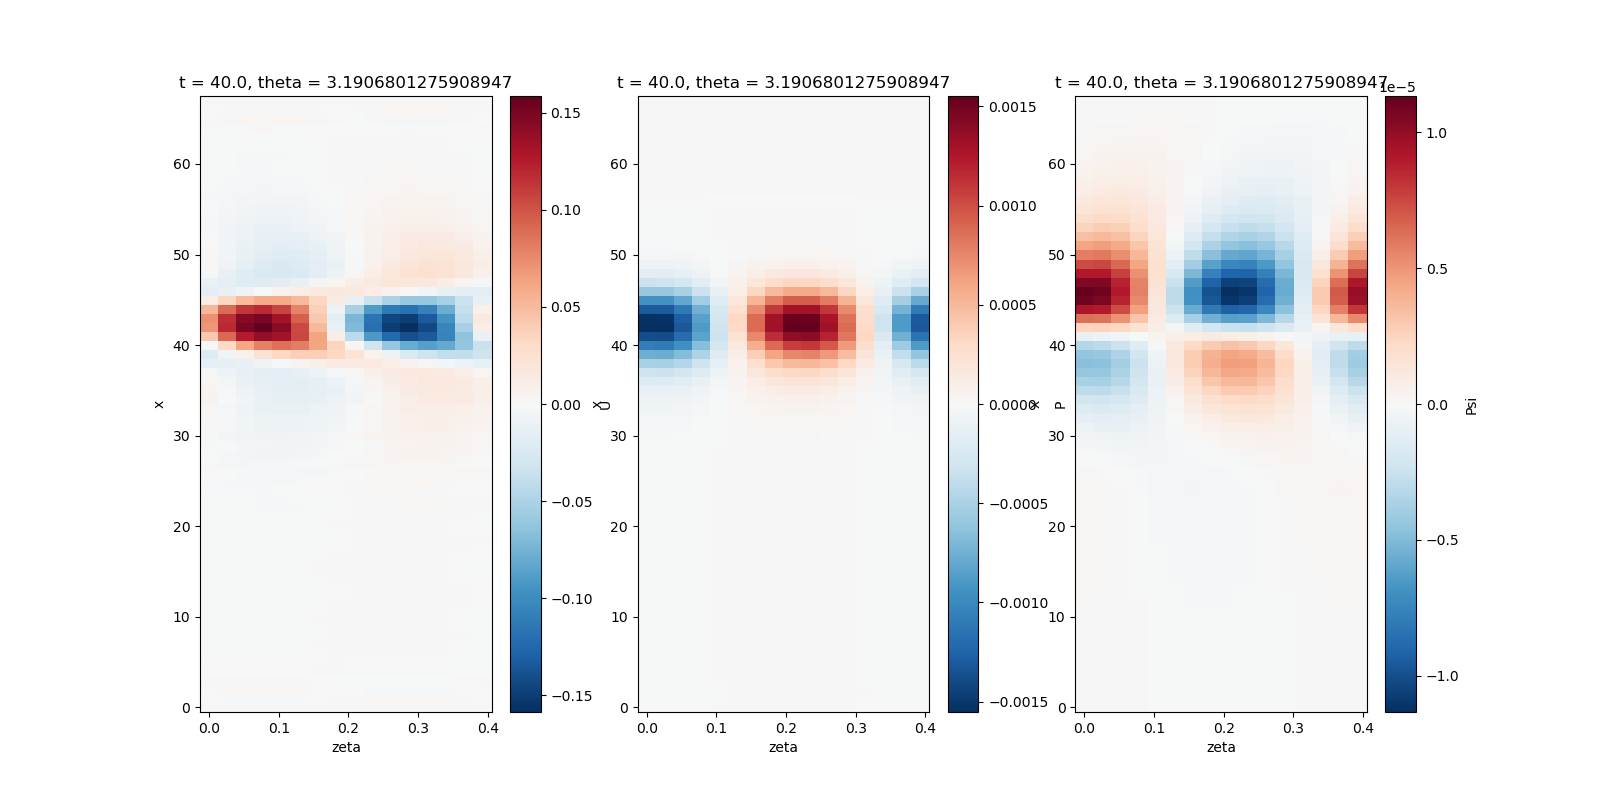

In [7]:
# radial-toroidal
# Uses xarray methods to plot simple slices
plt.figure()
plt.subplot(131)
ds_final.isel(theta=32)["U"].plot()
plt.subplot(132)
ds_final.isel(theta=32)["P"].plot()
plt.subplot(133)
ds_final.isel(theta=32)["Psi"].plot()

<IPython.core.display.Javascript object>


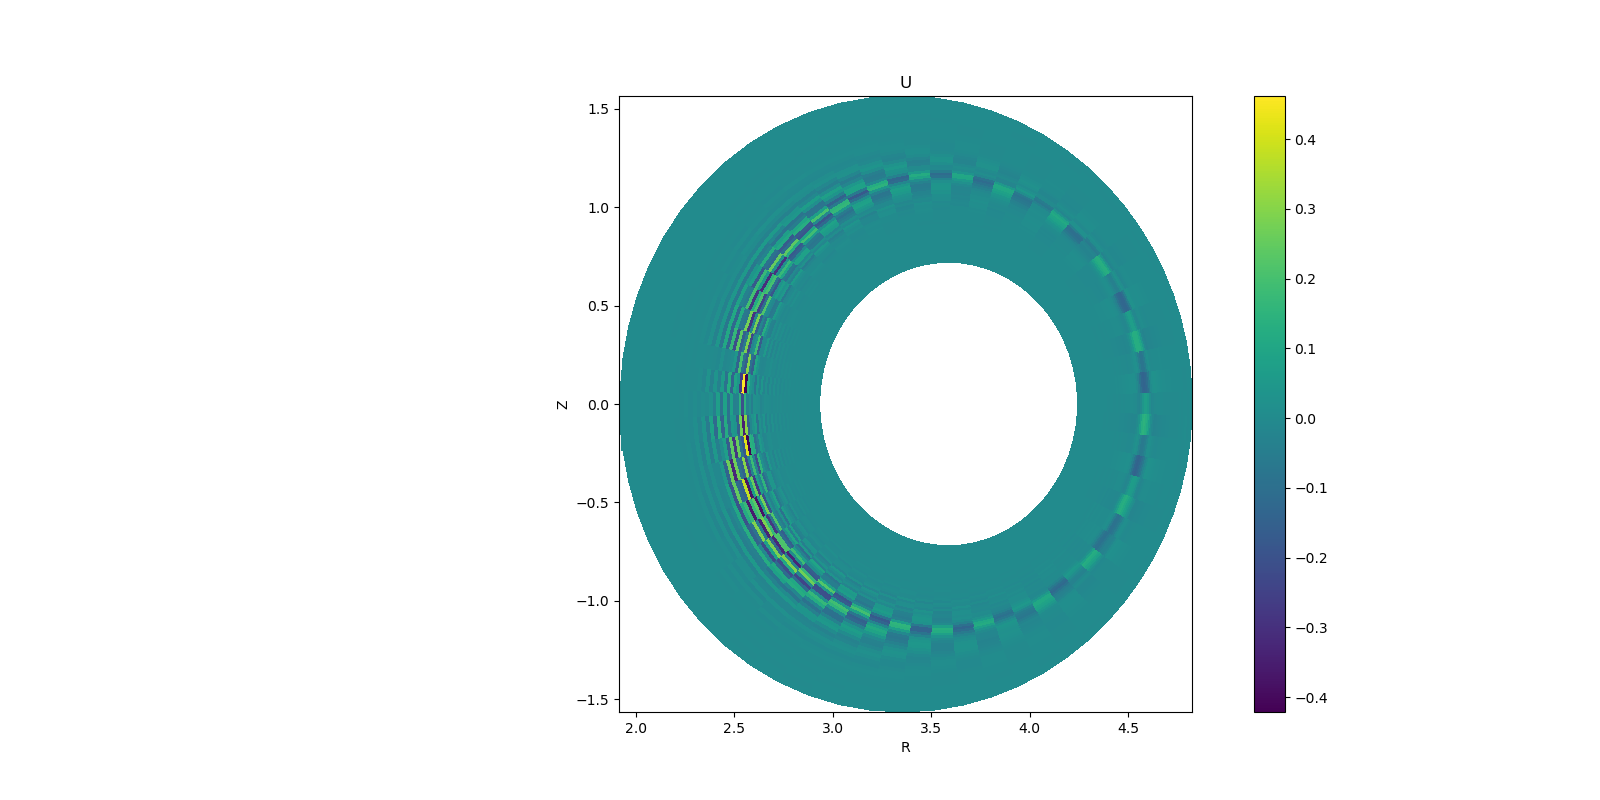

<IPython.core.display.Javascript object>


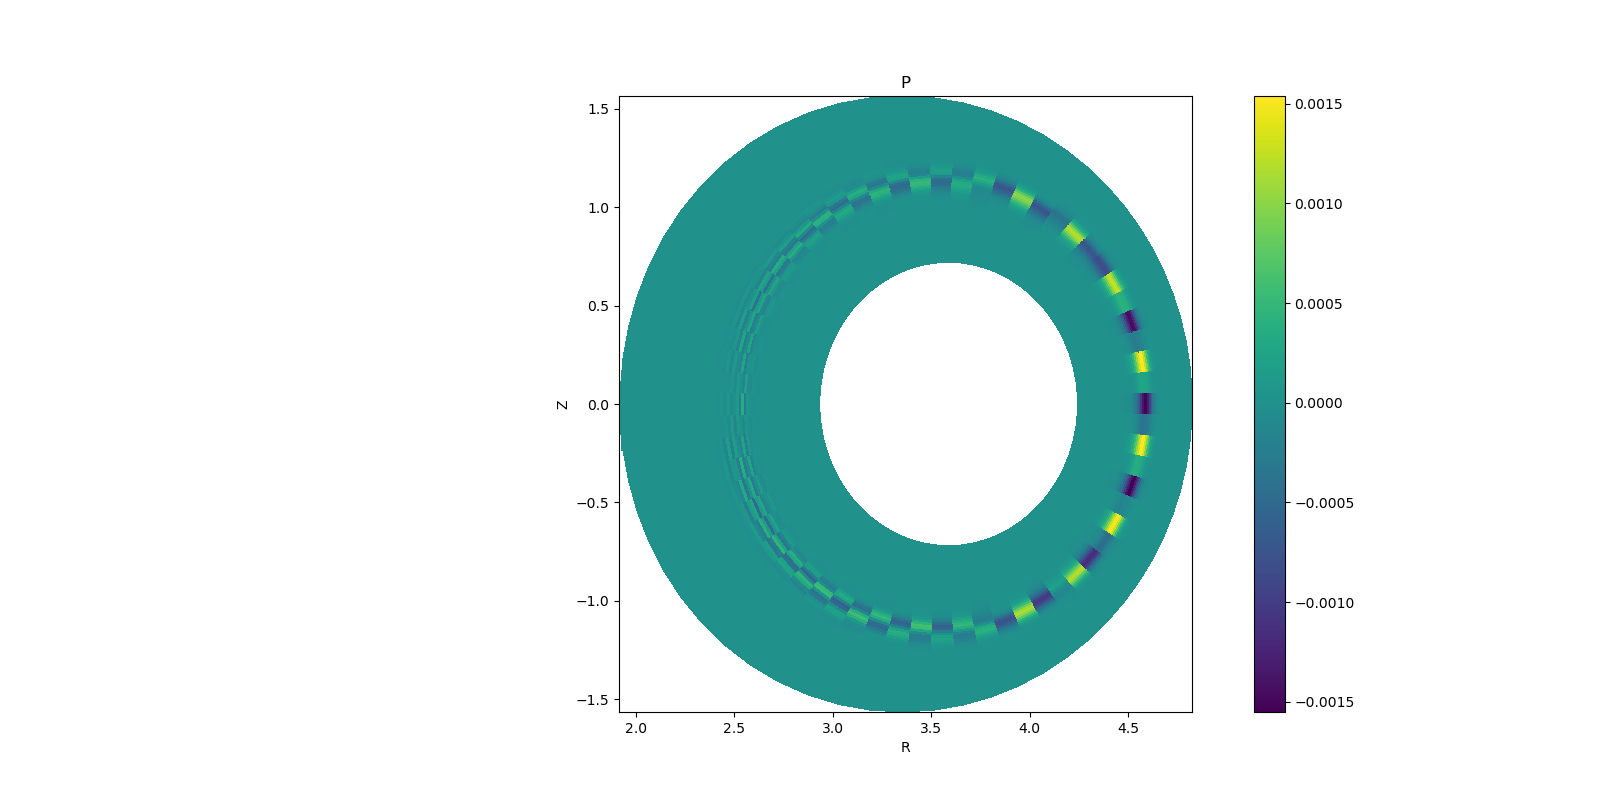

<IPython.core.display.Javascript object>


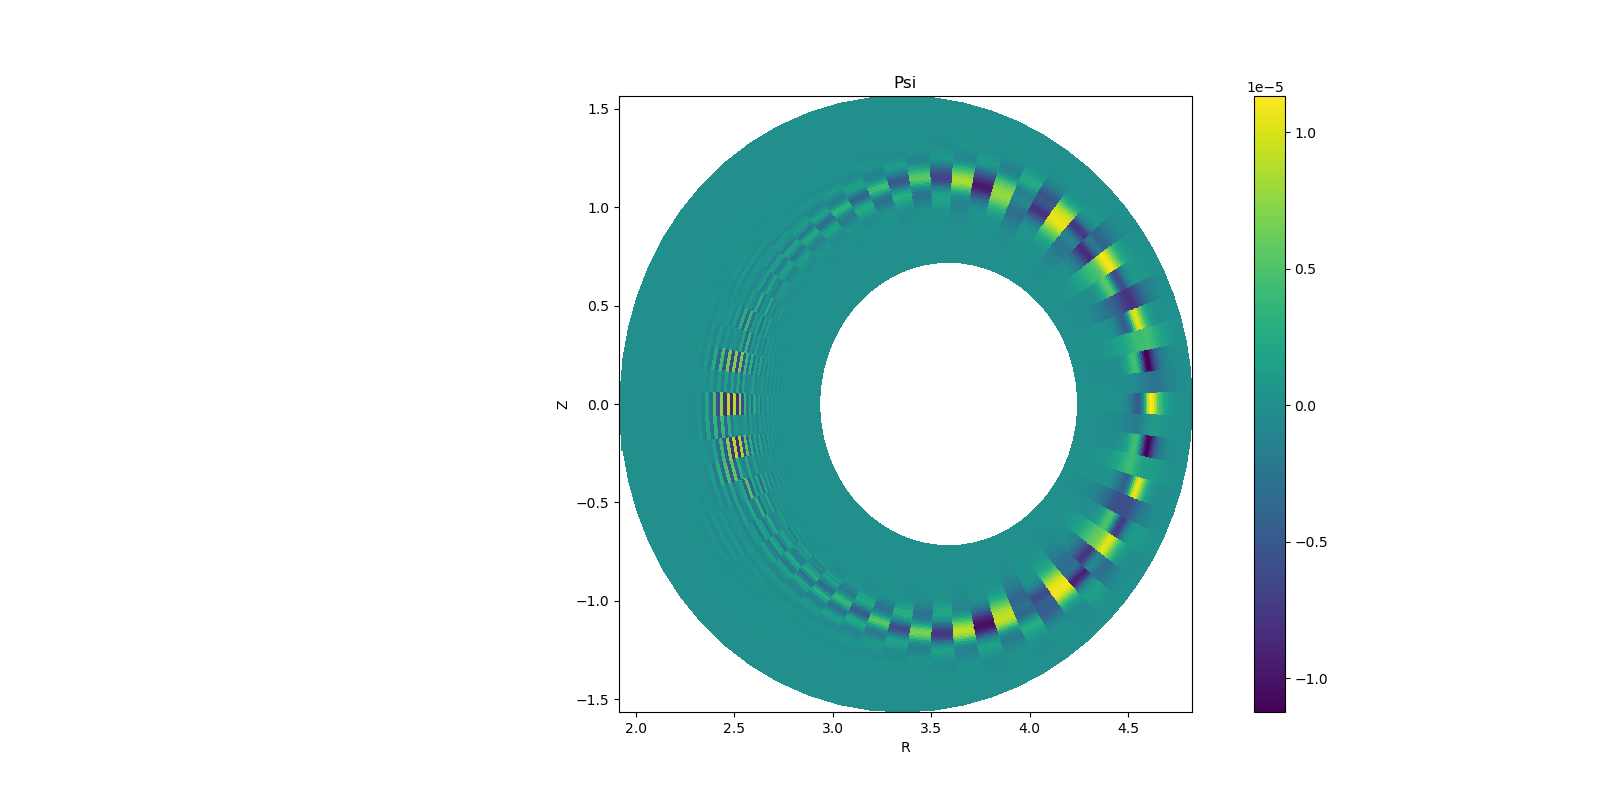

In [8]:
# poloidal plane
# Uses xbout method (called through the .bout 'accessor') to take account of geometry, plotting in poloidal plane.
# xbout plot calls include the plt.figure(), so no need to create new figures separately.
ds_final.isel(zeta=0)["U"].bout.pcolormesh()
ds_final.isel(zeta=0)["P"].bout.pcolormesh()
ds_final.isel(zeta=0)["Psi"].bout.pcolormesh()

<IPython.core.display.Javascript object>


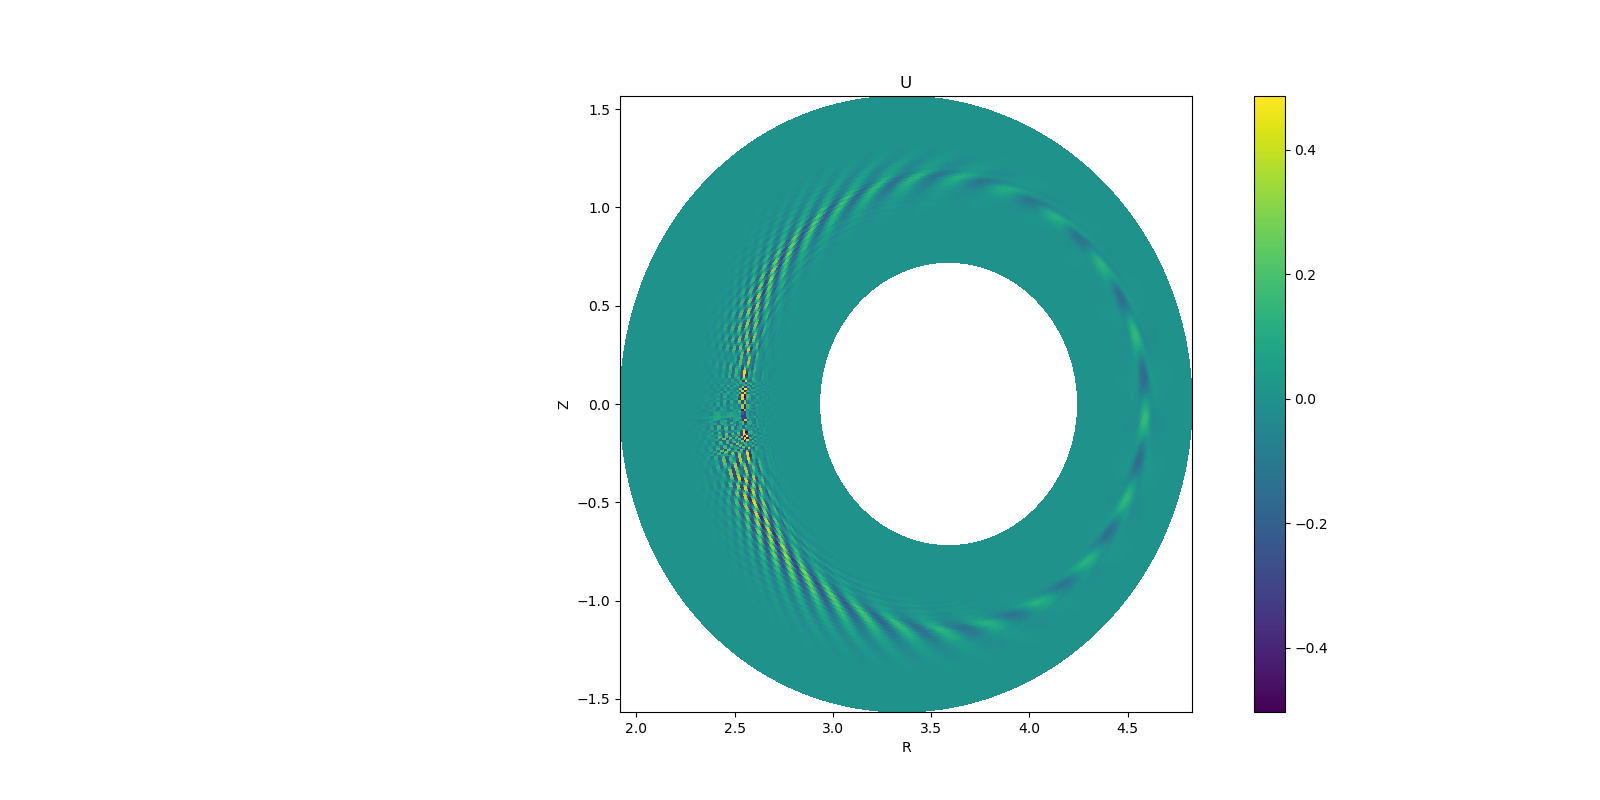

<IPython.core.display.Javascript object>


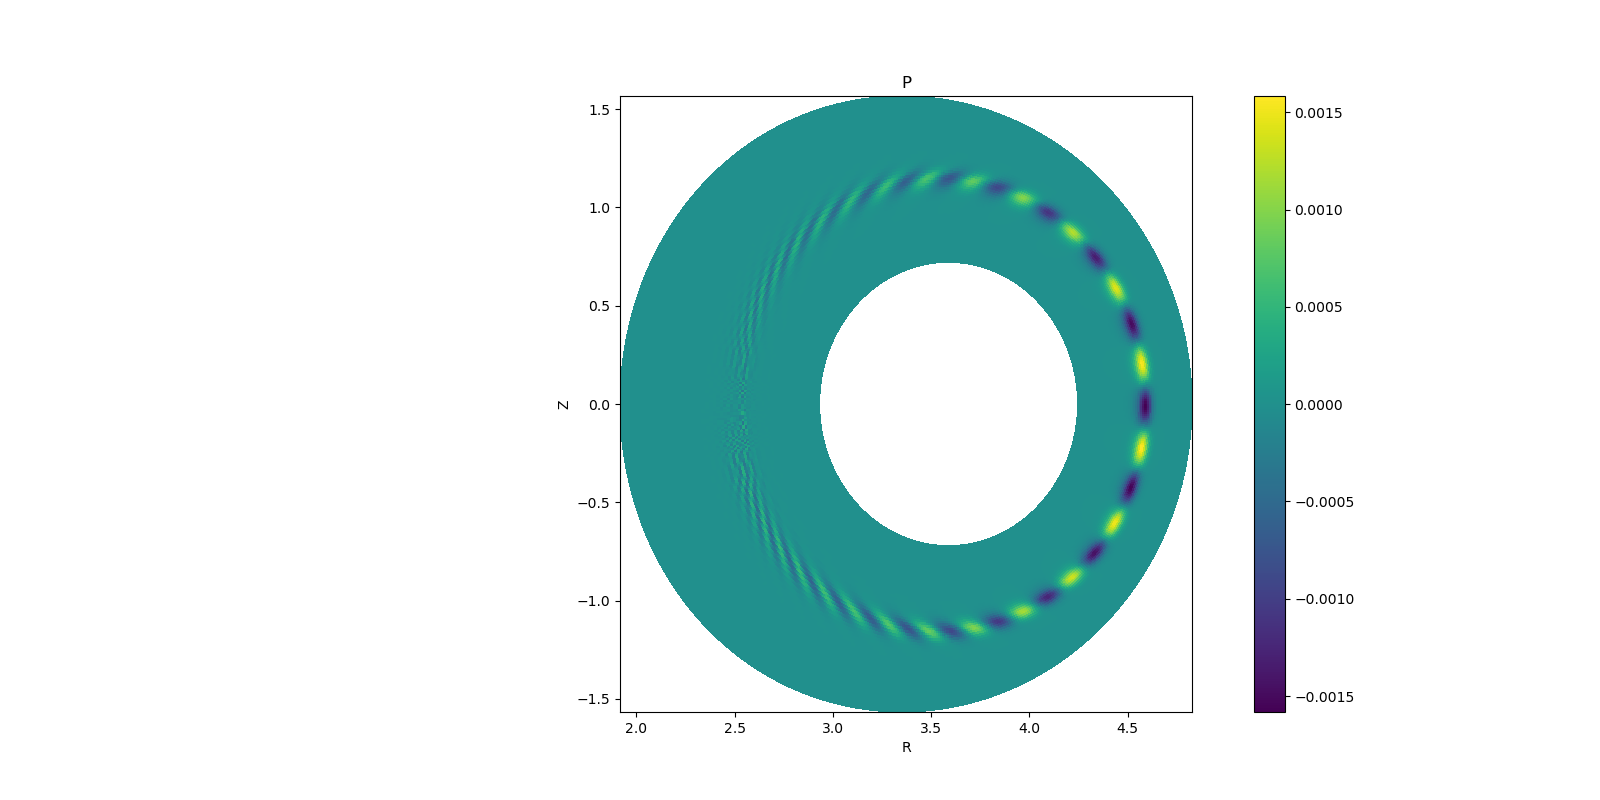

<IPython.core.display.Javascript object>


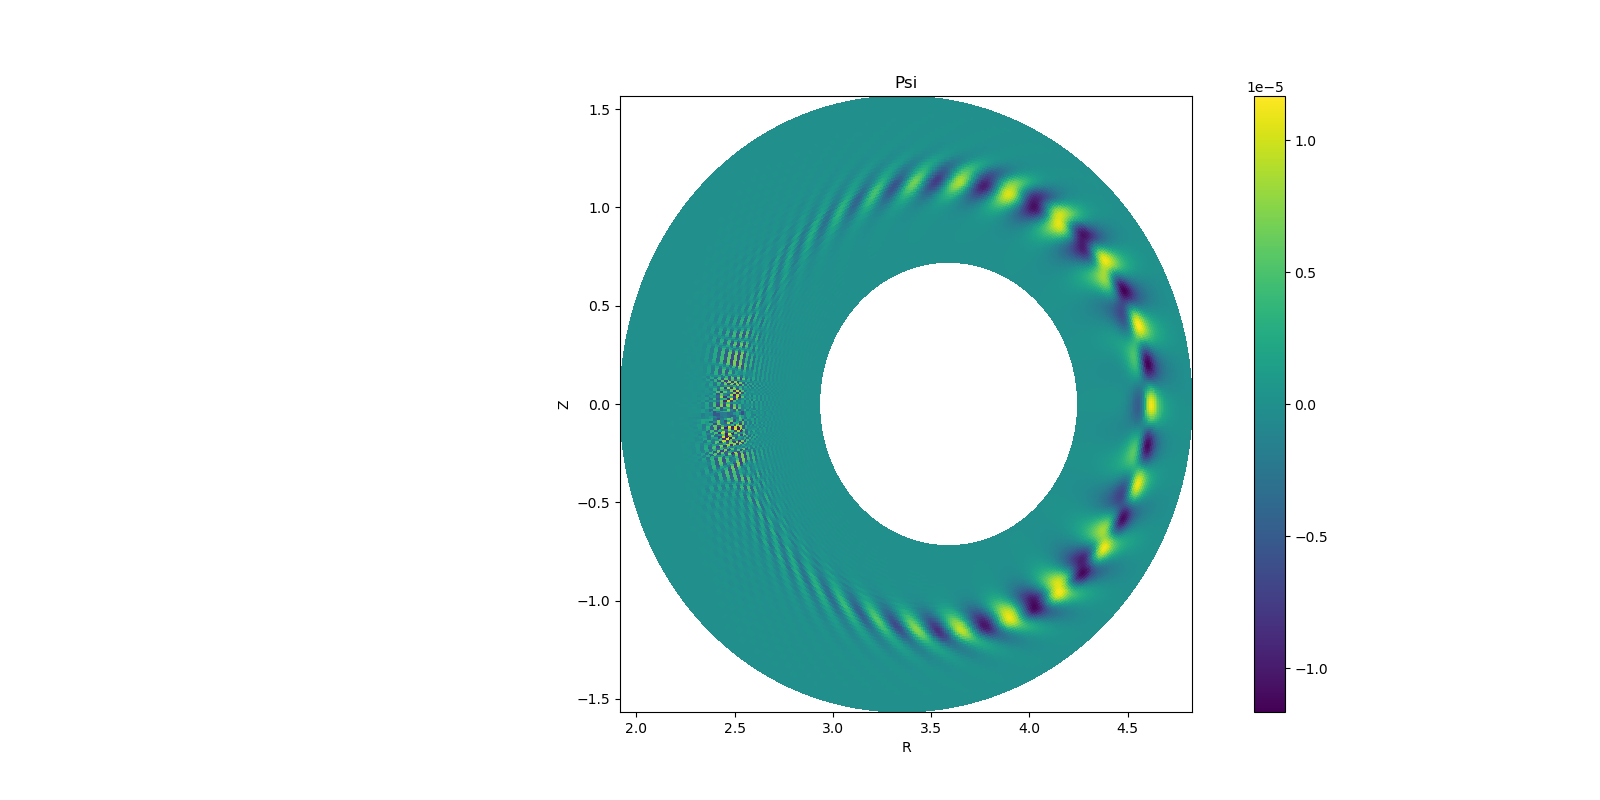

In [9]:
# poloidal plane
# Use interpolated Dataset to get increased poloidal resolution
ds_highres.isel(t=-1, zeta=0)["U"].bout.pcolormesh()
ds_highres.isel(t=-1, zeta=0)["P"].bout.pcolormesh()
ds_highres.isel(t=-1, zeta=0)["Psi"].bout.pcolormesh()

<IPython.core.display.Javascript object>


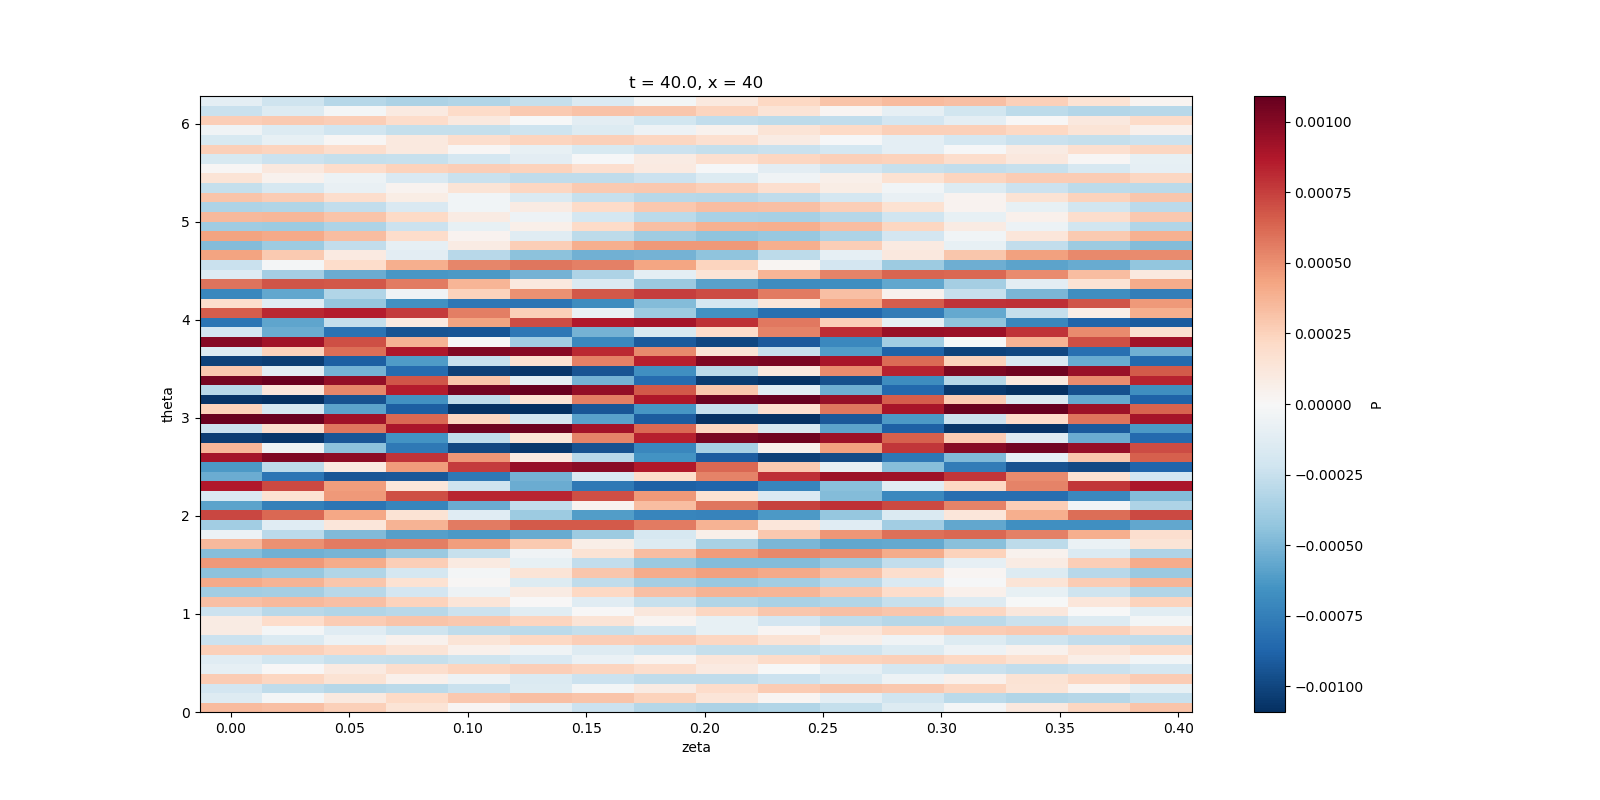

In [10]:
# Flux surface (poloidal-toroidal)
plt.figure()
ds["P"].isel(t=-1, x=40).plot()

<IPython.core.display.Javascript object>


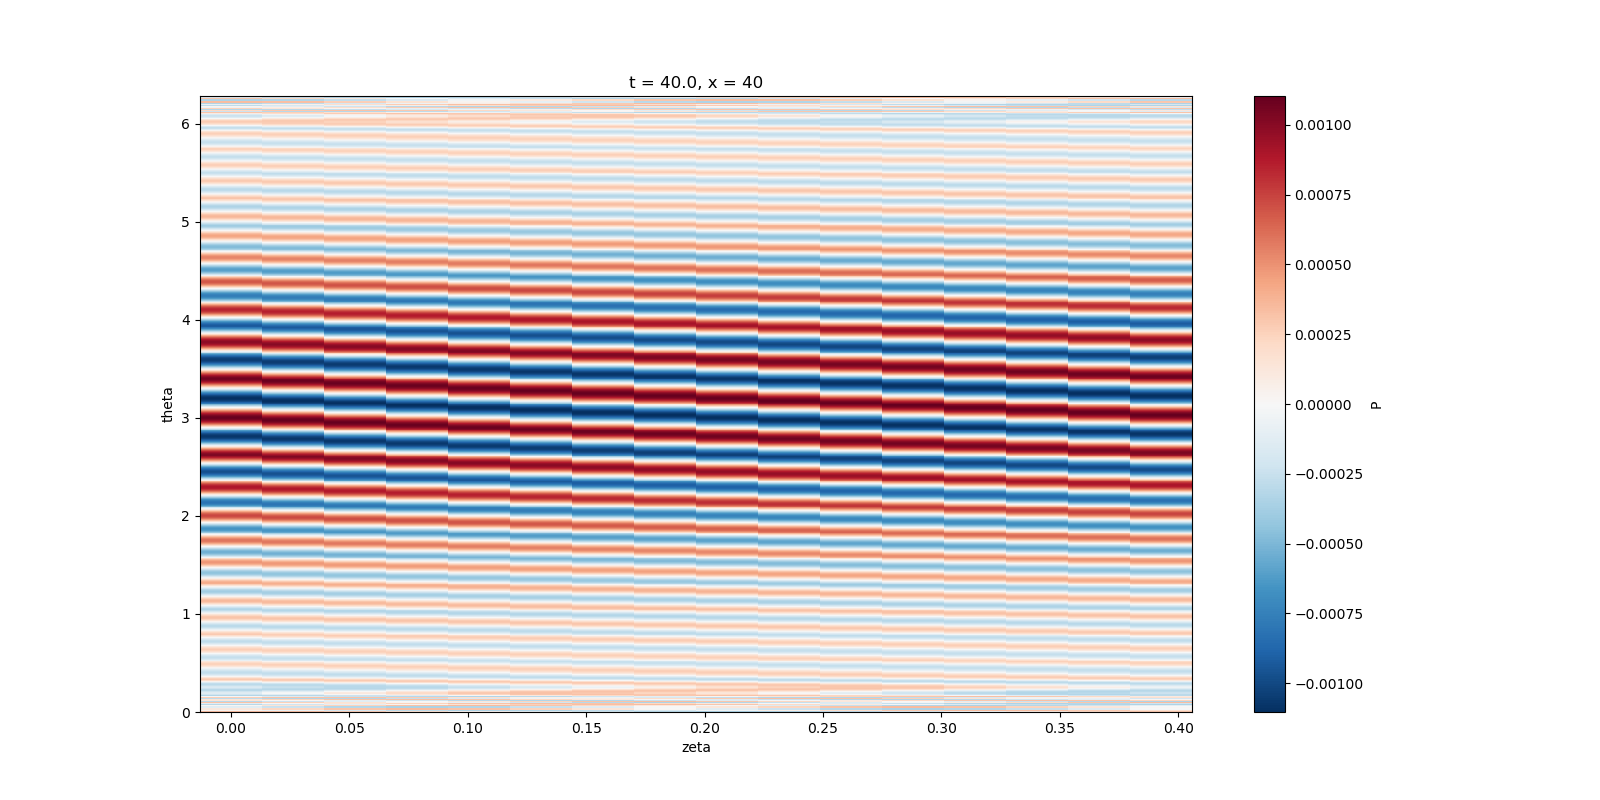

In [11]:
# Flux surface (poloidal-toroidal)
plt.figure()
ds_highres["P"].isel(t=-1, x=40).plot()

<IPython.core.display.Javascript object>


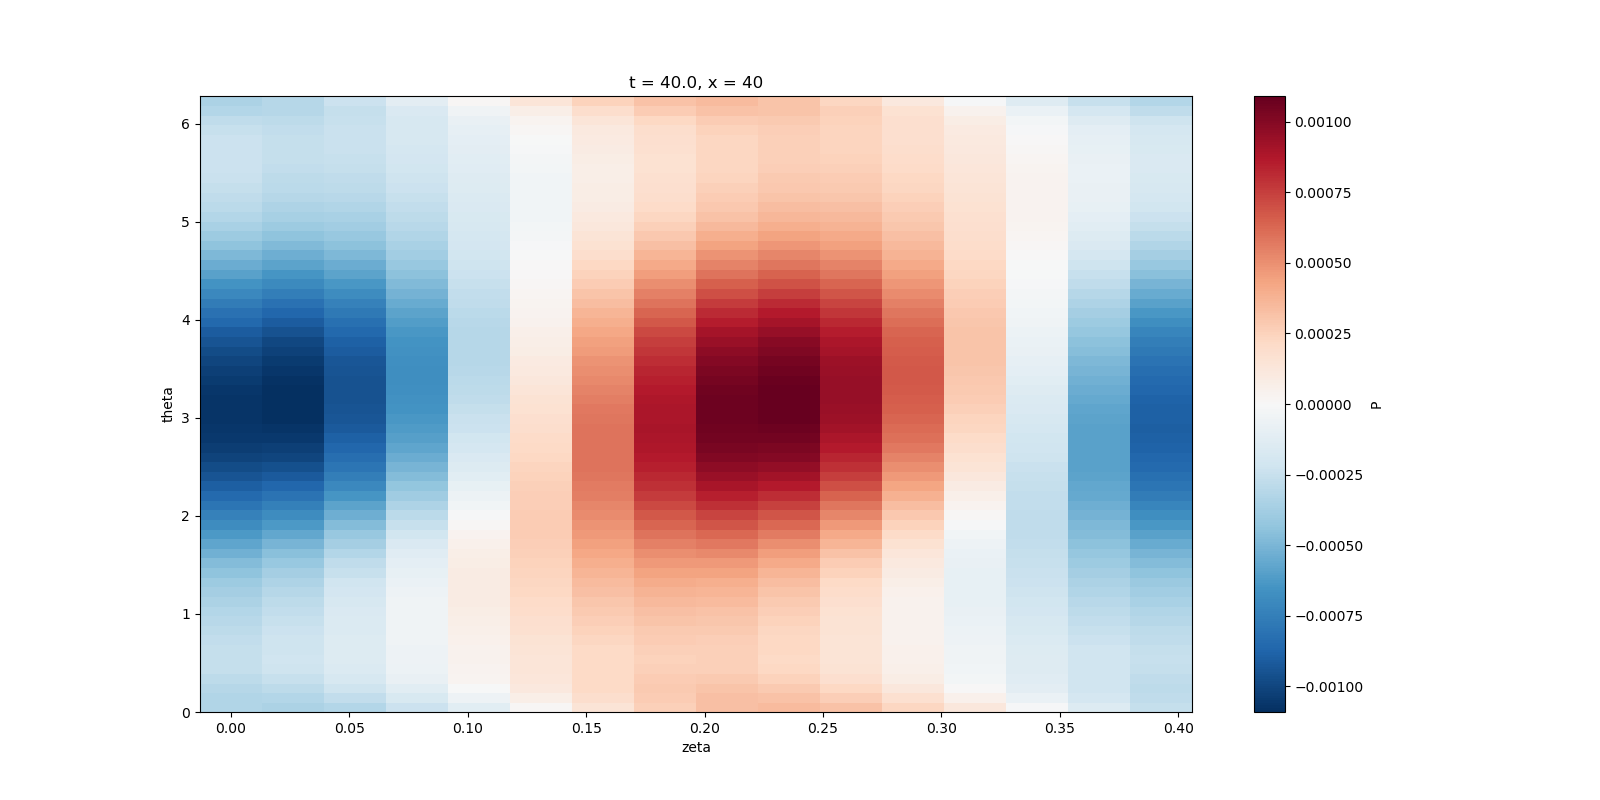

In [12]:
# Flux surface, transformed to field-aligned coordinates
plt.figure()
ds["P"].bout.to_field_aligned().isel(t=-1, x=40).plot()

<IPython.core.display.Javascript object>


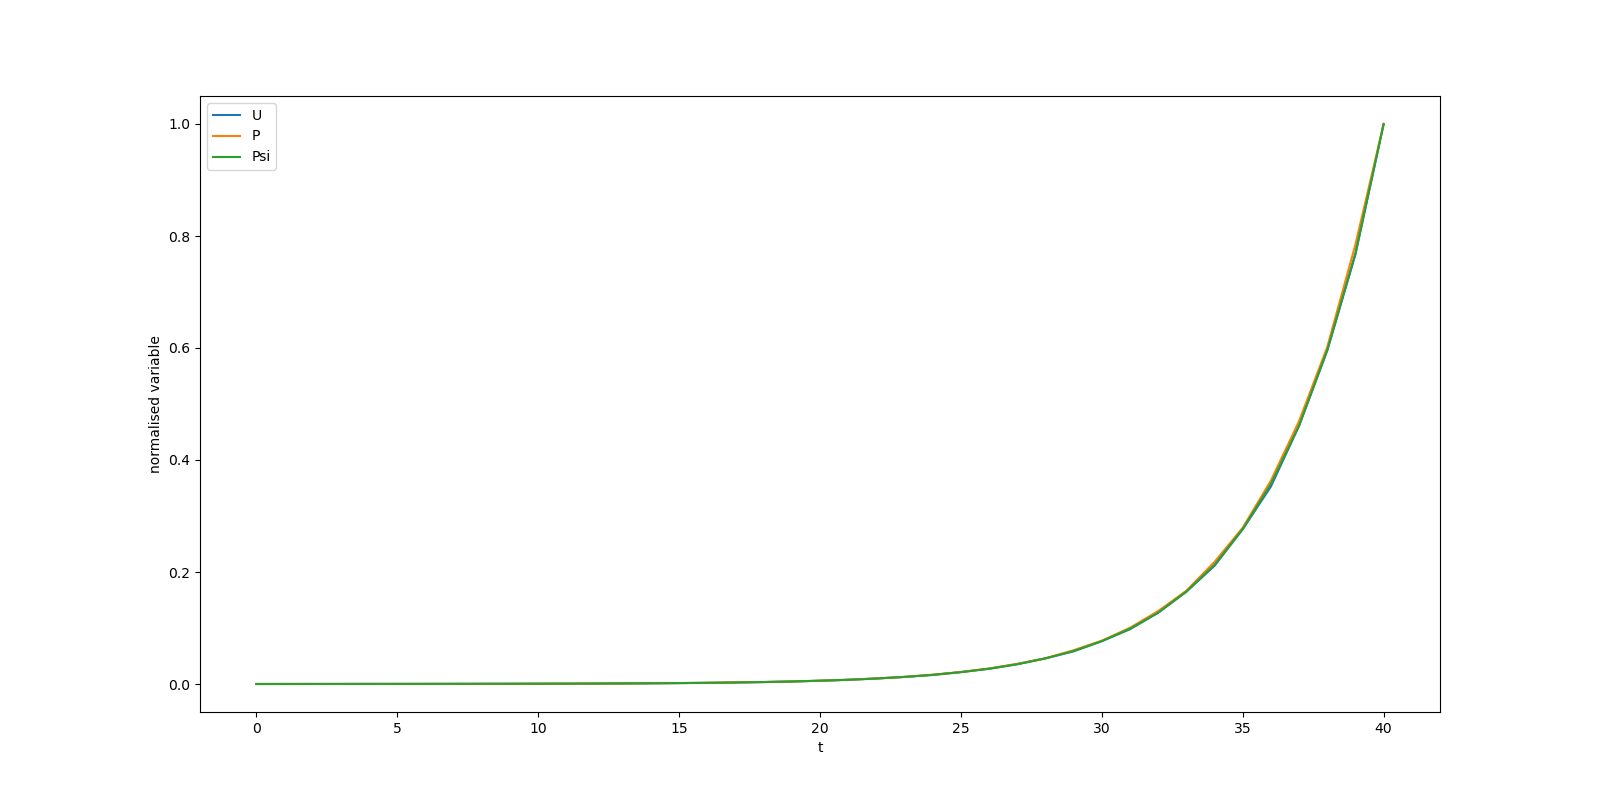

In [13]:
# Use some xarray methods for analysis

# Find spatial maximum to track mode growth
plt.figure() 
for var in ["U", "P", "Psi"]:
    varmax = ds[var].max(dim=["x", "theta", "zeta"])
    varmax = varmax / varmax.isel(t=-1)
    varmax.plot(label=var)
plt.ylabel("normalised variable")
plt.legend()

Animate
=======

Animations need to be interactive, so only show a frozen image in a saved notebook. Please download and run the notebook to see the animations

In [ ]:
# radial-toroidal plane
ds.isel(theta=32).bout.animate_list(["U", "P", "Psi"], ncols=3, logscale=True)

In [ ]:
# Poloidal plane
ds.isel(zeta=0).bout.animate_list(["U", "P", "Psi"], ncols=3, poloidal_plot=True)

In [ ]:
# Poloidal plot, with interpolation to get high resolution
# Animations can be saved by passing a 'save_as' argument giving a name for the output file
ds_highres.isel(zeta=0).bout.animate_list(["U", "P", "Psi"], ncols=3, poloidal_plot=True, save_as="poloidal_plot")

Extras
=====

In [14]:
# Create normalised psi_N coordinate

# open grid file to get some extra variables
grid = open_boutdataset("cbm18_dens8.grid_nx68ny64.nc", info=False)
psi_axis = grid.metadata["psi_axis"]
psi_bndry = grid.metadata["psi_bndry"]

psi_N = (ds["psi_poloidal"] - psi_axis)/(psi_bndry - psi_axis)
ds = ds.assign_coords(psi_N=psi_N)

# Extra coordinates to make a toroidal plot
ds = ds.assign_coords(xtilde=ds["psi_N"]*np.cos(ds["zeta"]), ytilde=ds["psi_N"]*np.sin(ds["zeta"]))

<IPython.core.display.Javascript object>


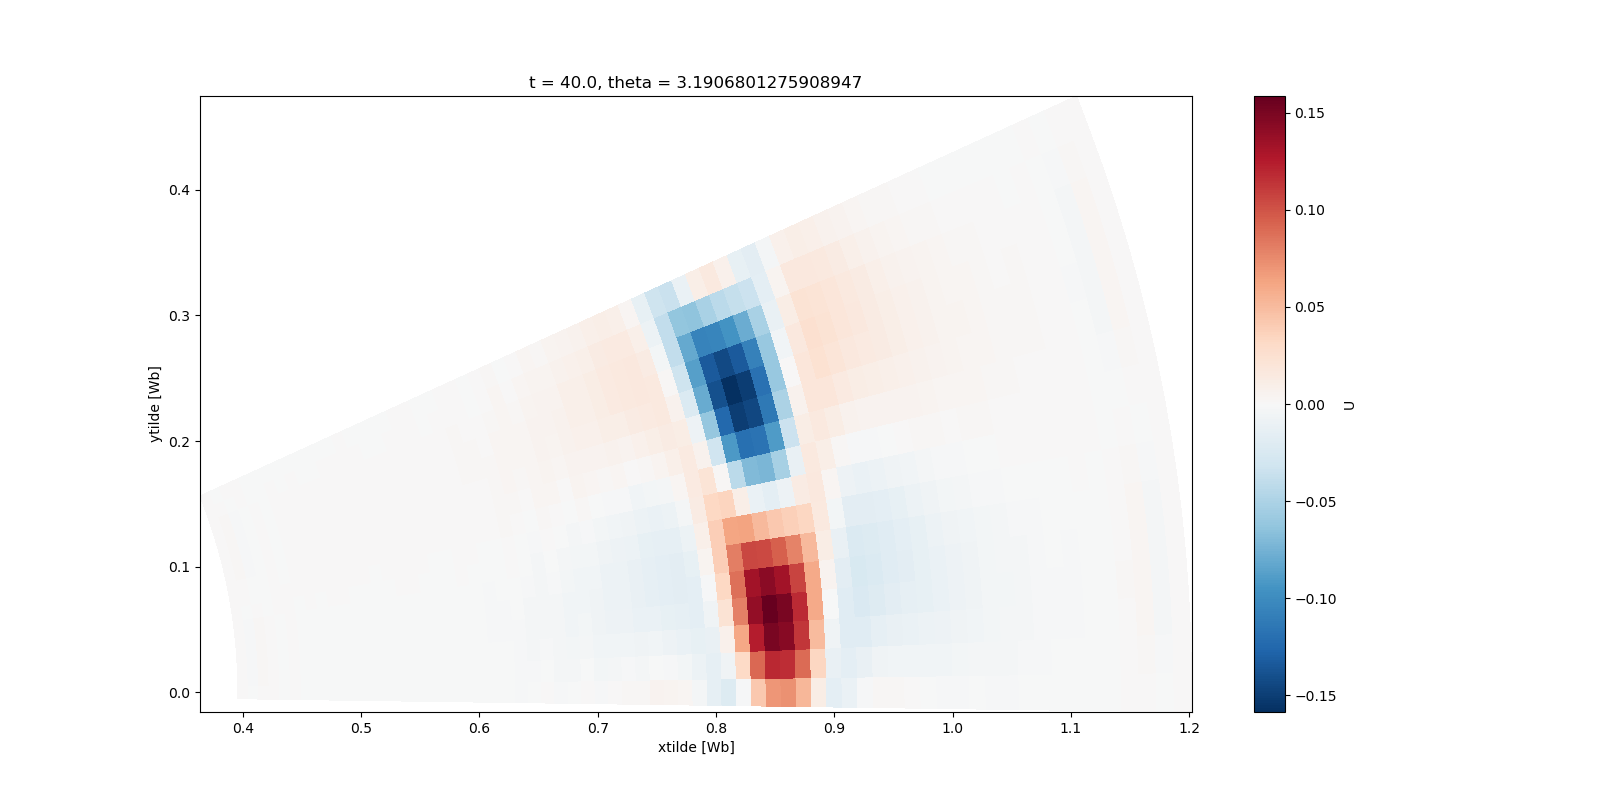

In [15]:
# Show a 'toroidal' plot of a radial-toroidal plane.
# Simulation uses zperiod=15, so this is 1/15 of an annulus
plt.figure()
ds["U"].isel(t=-1, theta=32).plot(x="xtilde", y="ytilde")